# 使用geatpy优化SVM-SVR定位模型参数

In [1]:
import joblib
import math
import numpy as np
import pandas as pd
import geatpy as ea
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, mean_squared_error

## 读取数据

In [2]:
# 加载训练数据
def load_data(path):
    df = pd.read_csv(path)
    dv = df.values
    X = dv[:, 1:-2]
    Y = dv[:, -2:]
    return X[:, :, np.newaxis], Y

In [3]:
X, y = load_data('./dataset/location_data.csv')
print(X.shape)
X = np.reshape(X, (2000, 100))

(2000, 100, 1)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)  # 训练测试划分

In [5]:
# 将y划分为坐标(x，y)使用两个模型分别做预测
y_train_x = y_train[:, 0]
y_train_y = y_train[:, 1]
y_test_x = y_test[:, 0]
y_test_y = y_test[:, 1]

In [6]:
%%time
svr = svm.SVR(kernel ='rbf').fit(X_train, y_train_x)  # 测试单次训练时间

CPU times: user 263 ms, sys: 5.69 ms, total: 268 ms
Wall time: 273 ms


## 使用进化算法调参

### model1-回归x坐标

 #### 自定义问题类

In [11]:
class RFIDSVMX(ea.Problem):
    def __init__(self, X_train, X_test, y_train_x, y_test_x):
        name = 'RFIDSVMX'
        M = 1 # 初始化M（目标维数）
        maxormins = [-1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 2 # 初始化Dim（决策变量维数）
        varTypes = [0, 0] # 初始化varTypes 0-连续
        lb = [1, 1e-10] # 决策变量下界
        ub = [500, 1] # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 数据设置
        self.X_train = X_train
        self.X_test = X_test
        self.y_train_x = y_train_x
        self.y_test_x = y_test_x
        
        
    # 目标函数，采用多线程加速计算
    def aimFunc(self, pop):
        Vars = pop.Phen # 得到决策变量矩阵
        # print(Vars)
        pop.ObjV = np.zeros((pop.sizes, 1)) # 初始化种群个体目标函数值列向量
        def subAimFunc(i):
            C = Vars[i, 0]
            G = Vars[i, 1]
            svr = svm.SVR(kernel ='rbf', C=C, gamma=G).fit(self.X_train, self.y_train_x) # 创建分类器对象并用训练集的数据拟合分类器模型
            scores = cross_val_score(svr, self.X_train, self.y_train_x, cv=5, scoring='neg_mean_absolute_error') # 这里可否改为MAE或者MSE做目标函数？
            pop.ObjV[i] = scores.mean() # 把交叉验证的平均得分作为目标函数值
        pool = ThreadPool(processes=2) # 设置池的大小
        pool.map(subAimFunc, list(range(pop.sizes)))
        
        
    # 代入优化后的C、Gamma对测试集进行检验，计算指标
    def test(self, C, G):
        svr = svm.SVR(kernel ='rbf', C=C, gamma=G).fit(self.X_train, self.y_train_x)
        joblib.dump(svr, './models/SVR_x_2021.model')
        y_predict_x = svr.predict(self.X_test) # 采用训练好的分类器对象对测试集数据进行预测
        print(y_predict_x[:10])
        print(self.y_test_x[:10])
        MAE = mean_absolute_error(y_test_x, y_predict_x)
        MSE = mean_squared_error(y_test_x, y_predict_x)
        r2 = r2_score(y_test_x, y_predict_x)
        ev = explained_variance_score(y_test_x, y_predict_x)
        print('MAE指标:', MAE)
        print('MSE指标:', MSE)
        print('RMSE指标:', math.sqrt(MSE))
        print('r2指标:', r2)
        print('ev指标:', ev)
        return y_predict_x
        

#### 编写执行代码

gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   20   | -2.43883E+00| -2.43883E+00| -2.43883E+00| -2.43883E+00| 2.35348E-09 
 1 |   40   | -2.43819E+00| -2.43819E+00| -2.43880E+00| -2.43883E+00| 1.39530E-04 
 2 |   60   | -2.43819E+00| -2.43819E+00| -2.43880E+00| -2.43883E+00| 1.39530E-04 
 3 |   80   | -2.39871E+00| -2.39871E+00| -2.43678E+00| -2.43883E+00| 8.73628E-03 
 4 |  100   | -2.30696E+00| -2.30696E+00| -2.41428E+00| -2.43883E+00| 4.22318E-02 
 5 |  120   | -2.30696E+00| -2.30696E+00| -2.40377E+00| -2.43883E+00| 4.44742E-02 
 6 |  140   | -2.07370E+00| -2.07370E+00| -2.37060E+00| -2.43883E+00| 8.18410E-02 
 7 |  160   | -2.07370E+00| -2.07370E+00| -2.35036E+00| -2.43883E+00| 1.01416E-01 
 8 |  180   | -9.41679E-01| -9.41679E-01| -2.24743E+00| -2.43807E+00| 3.23897E-01 
 9 |  200   | -8.40906E-01| -8.40906E-01| -2.08682E+00| -2.41926E+00| 4.42348E-01 
 10|

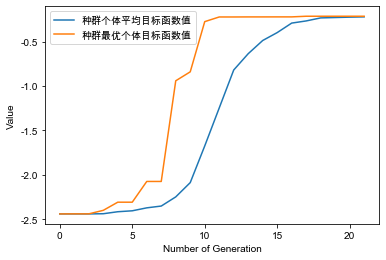

种群信息导出完毕。
用时：408.032144 秒
评价次数：440 次
最优的目标函数值为：-0.21577469082261577
最优的控制变量值为：
1.0
0.00023208847771970042
[3.96387446 1.52055414 5.09058174 9.36767898 7.33982735 8.88050011
 9.31559196 3.88349962 9.02492212 2.31965825]
[3.76 1.57 5.43 9.67 7.09 8.59 9.14 3.66 8.93 2.38]
MAE指标: 0.2040970498309335
MSE指标: 0.06729412813233865
RMSE指标: 0.2594111179813592
r2指标: 0.9913511044436396
ev指标: 0.9913546537778252


In [12]:
"""===============================实例化问题对象==========================="""

problem = RFIDSVMX(X_train, X_test, y_train_x, y_test_x) # 生成问题对象

"""=================================种群设置==============================="""

Encoding = 'RI'       # 编码方式
NIND = 20             # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）

"""===============================算法参数设置============================="""

myAlgorithm = ea.soea_DE_rand_1_bin_templet(problem, population) # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 30 # 最大进化代数
myAlgorithm.trappedValue = 1e-6 # “进化停滞”判断阈值
myAlgorithm.maxTrappedCount = 10 # 进化停滞计数器最大上限值，如果连续maxTrappedCount代被判定进化陷入停滞，则终止进化
myAlgorithm.logTras = 1  # 设置每隔多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True  # 设置是否打印输出日志信息
myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）

"""===========================调用算法模板进行种群进化======================="""

[BestIndi, population] = myAlgorithm.run()  # 执行算法模板，得到最优个体以及最后一代种群
BestIndi.save()  # 把最优个体的信息保存到文件中

"""==================================输出结果============================="""

print('用时：%f 秒' % myAlgorithm.passTime)
print('评价次数：%d 次' % myAlgorithm.evalsNum)
if BestIndi.sizes != 0:
    print('最优的目标函数值为：%s' % BestIndi.ObjV[0][0])
    print('最优的控制变量值为：')
    for i in range(BestIndi.Phen.shape[1]):
        print(BestIndi.Phen[0, i])
else:
    print('没找到可行解。')
    
"""=================================检验结果==============================="""

y_predict_x = problem.test(C = BestIndi.Phen[0][0], G = BestIndi.Phen[0][1])


### model2-回归y坐标

 #### 自定义问题类

In [9]:
class RFIDSVMY(ea.Problem):
    def __init__(self, X_train, X_test, y_train_y, y_test_y):
        name = 'RFIDSVMY'
        M = 1 # 初始化M（目标维数）
        maxormins = [-1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 2 # 初始化Dim（决策变量维数）
        varTypes = [0, 0] # 初始化varTypes 0-连续
        lb = [1, 1e-10] # 决策变量下界
        ub = [500, 1] # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 数据设置
        self.X_train = X_train
        self.X_test = X_test
        self.y_train_y = y_train_y
        self.y_test_y = y_test_y
        
        
    # 目标函数，采用多线程加速计算
    def aimFunc(self, pop):
        Vars = pop.Phen # 得到决策变量矩阵
        pop.ObjV = np.zeros((pop.sizes, 1)) # 初始化种群个体目标函数值列向量
        def subAimFunc(i):
            C = Vars[i, 0]
            G = Vars[i, 1]
            svr = svm.SVR(kernel ='rbf', C=C, gamma=G).fit(self.X_train, self.y_train_y) # 创建分类器对象并用训练集的数据拟合分类器模型
            scores = cross_val_score(svr, self.X_train, self.y_train_y, cv=5, scoring='neg_mean_absolute_error')
            pop.ObjV[i] = scores.mean() # 把交叉验证的平均得分作为目标函数值
        pool = ThreadPool(processes=2) # 设置池的大小
        pool.map(subAimFunc, list(range(pop.sizes))) # 散列种群每个个体进行加速计算
        
        
    # 代入优化后的C、Gamma对测试集进行检验，计算指标
    def test(self, C, G):
        svr = svm.SVR(kernel ='rbf', C=C, gamma=G).fit(self.X_train, self.y_train_y)
        joblib.dump(svr, './models/SVR_y_2021.model')
        y_predict_y = svr.predict(self.X_test) # 采用训练好的分类器对象对测试集数据进行预测
        print(y_predict_y[:10])
        print(self.y_test_y[:10])
        MAE = mean_absolute_error(y_test_y, y_predict_y)
        MSE = mean_squared_error(y_test_y, y_predict_y)
        r2 = r2_score(y_test_y, y_predict_y)
        ev = explained_variance_score(y_test_y, y_predict_y)
        print('MAE指标:', MAE)
        print('MSE指标:', MSE)
        print('RMSE指标:', math.sqrt(MSE))
        print('r2指标:', r2)
        print('ev指标:', ev)
        return y_predict_y
        

 #### 编写执行代码

gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   20   | -2.39212E+00| -2.39212E+00| -2.39212E+00| -2.39212E+00| 4.44089E-16 
 1 |   40   | -2.39212E+00| -2.39212E+00| -2.39212E+00| -2.39212E+00| 4.44089E-16 
 2 |   60   | -2.39212E+00| -2.39212E+00| -2.39212E+00| -2.39212E+00| 4.44089E-16 
 3 |   80   | -2.37220E+00| -2.37220E+00| -2.39113E+00| -2.39212E+00| 4.34323E-03 
 4 |  100   | -2.36272E+00| -2.36272E+00| -2.38966E+00| -2.39212E+00| 7.54957E-03 
 5 |  120   | -2.35881E+00| -2.35881E+00| -2.38824E+00| -2.39212E+00| 9.49260E-03 
 6 |  140   | -2.35858E+00| -2.35858E+00| -2.38583E+00| -2.39212E+00| 1.06639E-02 
 7 |  160   | -2.35394E+00| -2.35394E+00| -2.38312E+00| -2.39212E+00| 1.27133E-02 
 8 |  180   | -2.35394E+00| -2.35394E+00| -2.38113E+00| -2.39212E+00| 1.23586E-02 
 9 |  200   | -2.35271E+00| -2.35271E+00| -2.37704E+00| -2.39212E+00| 1.38679E-02 
 10|

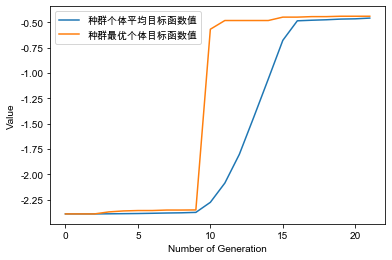

种群信息导出完毕。
用时：431.285258 秒
评价次数：440 次
最优的目标函数值为：-0.43894652110848903
最优的控制变量值为：
2.2565300801543344
0.00035859857772423706
[3.44676388 4.78428487 7.01894283 7.85498384 8.26634749 7.91657261
 4.37878486 8.47368304 2.53420984 1.93612744]
[3.77 4.63 6.77 7.94 8.28 8.24 2.22 7.91 1.86 2.02]
MAE指标: 0.4330135047331426
MSE指标: 0.33653655908607116
RMSE指标: 0.5801177114052554
r2指标: 0.952655923877918
ev指标: 0.9530808789321835


In [10]:
"""===============================实例化问题对象==========================="""

problem = RFIDSVMY(X_train, X_test, y_train_y, y_test_y) # 生成问题对象

"""=================================种群设置==============================="""

Encoding = 'RI'       # 编码方式
NIND = 20             # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）

"""===============================算法参数设置============================="""

myAlgorithm = ea.soea_DE_rand_1_bin_templet(problem, population) # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 30 # 最大进化代数
myAlgorithm.trappedValue = 1e-6 # “进化停滞”判断阈值
myAlgorithm.maxTrappedCount = 10 # 进化停滞计数器最大上限值，如果连续maxTrappedCount代被判定进化陷入停滞，则终止进化
myAlgorithm.logTras = 1  # 设置每隔多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True  # 设置是否打印输出日志信息
myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）

"""===========================调用算法模板进行种群进化======================="""

[BestIndi, population] = myAlgorithm.run()  # 执行算法模板，得到最优个体以及最后一代种群
BestIndi.save()  # 把最优个体的信息保存到文件中

"""==================================输出结果============================="""

print('用时：%f 秒' % myAlgorithm.passTime)
print('评价次数：%d 次' % myAlgorithm.evalsNum)
if BestIndi.sizes != 0:
    print('最优的目标函数值为：%s' % BestIndi.ObjV[0][0])
    print('最优的控制变量值为：')
    for i in range(BestIndi.Phen.shape[1]):
        print(BestIndi.Phen[0, i])
else:
    print('没找到可行解。')
    
"""=================================检验结果==============================="""

y_predict_y = problem.test(C = BestIndi.Phen[0][0], G = BestIndi.Phen[0][1])


### 计算整体指标

In [13]:
pxy = [[xi, yi] for xi, yi in zip(y_predict_x, y_predict_y)]
print(pxy[:10])
print('坐标(x,y)的MAE:', mean_absolute_error(y_test, pxy))
print('坐标(x,y)的MSE:', mean_squared_error(y_test, pxy))
print('坐标(x,y)的RMSE:', math.sqrt(mean_squared_error(y_test, pxy)))
print('坐标(x,y)的r2:', r2_score(y_test, pxy))
print('坐标(x,y)的ev:', explained_variance_score(y_test, pxy))

[[3.963874462668693, 3.4467638827304765], [1.520554143278307, 4.784284865111279], [5.090581743868404, 7.018942834985399], [9.367678979415187, 7.854983840373522], [7.339827348909546, 8.266347494205629], [8.8805001067507, 7.916572614757769], [9.31559196137628, 4.378784861629384], [3.8834996191495086, 8.473683039331146], [9.024922121776878, 2.534209835950706], [2.3196582483717814, 1.9361274395935397]]
坐标(x,y)的MAE: 0.31855527728203803
坐标(x,y)的MSE: 0.20191534360920493
坐标(x,y)的RMSE: 0.44934991221675447
坐标(x,y)的r2: 0.9720035141607788
坐标(x,y)的ev: 0.9722177663550043
